In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
cwd = os.getcwd()

In [3]:
raw_posts = pd.read_csv(cwd + '//AAPL Reddit Data//five-years-of-aapl-on-reddit-posts.csv')
raw_comments = pd.read_csv(cwd + '//AAPL Reddit Data//five-years-of-aapl-on-reddit-comments.csv')

##### Check no comments were erroneously added to the 'post' csv:

In [4]:
print(f"The raw_posts dataframe contains the types: {raw_posts['type'].unique()}")
print(f"The raw_comments dataframe contains the types: {raw_comments['type'].unique()}")

The raw_posts dataframe contains the types: ['post']
The raw_comments dataframe contains the types: ['comment']


#### All good.
##### A quick check of posts in nsfw subreddits tells us that the popularity of such posts is low (not exceeding a score of 11). For this reason, and that nsfw subreddits are unlikely to contain serious discussion of the AAPL ticker, they are dropped.

In [5]:
raw_posts[raw_posts['subreddit.nsfw'] == True][['subreddit.name', 'score']].max()

subreddit.name    worldpolitics
score                        11
dtype: object

In [6]:
raw_posts = raw_posts[raw_posts['subreddit.nsfw'] == False].copy()

##### Drop unneeded columns from each dataframe

In [7]:
raw_posts_comms = [raw_posts, raw_comments]
columns=['type', 'subreddit.id', 'subreddit.nsfw', 'permalink', 'domain', 'url']

def drop_columns(dfs, columns):
    for df in dfs:
        for col in columns:
            if col in list(df.columns):
                df.drop(columns=col, inplace=True)
            else:
                print('No columns could be dropped')

In [8]:
drop_columns(raw_posts_comms, columns)

No columns could be dropped
No columns could be dropped


##### Convert unix time values to datetime objects:

In [9]:
from datetime import datetime

In [10]:
def convert_datetime(dfs):
    for df in dfs:
        df['created_utc'] = df['created_utc'].apply(
            lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

        df.rename(columns={'created_utc': 'time_created'}, inplace=True)

        df['time_created'] = pd.to_datetime(df['time_created'])
        
def add_time_cols(dfs):
    for df in dfs:
        df['year_created'] = df['time_created'].dt.year
        df['month_created'] = df['time_created'].dt.month
        df['day_created'] = df['time_created'].dt.day
        
        df.rename(
            columns={'time_created': 'date_created',
                     'subreddit.name': 'subreddit',
                    }, inplace=True)
        
        df['hour_created'] = df['date_created'].dt.hour

In [11]:
convert_datetime(raw_posts_comms)
add_time_cols(raw_posts_comms)

In [12]:
clean_posts = raw_posts.copy()
clean_comms = raw_comments.copy()

In [13]:
clean_posts.head()

,id,subreddit,date_created,selftext,title,score,year_created,month_created,day_created,hour_created
0,qjx7sk,dividends,2021-10-31 19:48:40,I have created a package of dividend stocks by...,Why is AAPL included in dividend ETFs?,7,2021,10,31,19
1,qjx3kk,aapl,2021-10-31 19:42:55,The market has now gifted MSFT (a great but in...,why AAPL deserves $200+ and a 35+ PE,7,2021,10,31,19
2,qjvocf,ultraalgo,2021-10-31 18:34:12,NaN,$AAPL waiting for Buy signal on AAPL https://t...,1,2021,10,31,18
3,qjvo1l,stocks,2021-10-31 18:33:50,I've got about 5.5% AAPL and 11.1% MSFT. I'm ...,Sell a few AAPL shares and buy CRM?,8,2021,10,31,18
4,qjtshr,stocks,2021-10-31 17:02:20,I’m a broke college student but I have enough ...,Is $AAPL able to grow much more?,162,2021,10,31,17


In [14]:
clean_comms.head()

,id,subreddit,date_created,body,sentiment,score,year_created,month_created,day_created,hour_created
0,hitr97r,stocks,2021-10-31 23:56:19,I own all 3. Don't sell AAPL.,0.0000,1,2021,10,31,23
1,hitq83x,stocks,2021-10-31 23:47:22,I believe TSLA want to be like AAPL: part hard...,-0.2500,2,2021,10,31,23
2,hitp3wy,millennialbets,2021-10-31 23:37:43,**[Recent News for BABA-](https://www.reddit.c...,0.9422,1,2021,10,31,23
3,hitnu8x,dividends,2021-10-31 23:27:09,"O, AAPL, NKE",NaN,1,2021,10,31,23
4,hitmll9,stocks,2021-10-31 23:16:54,I have both. CRM has had better revenue and ea...,0.7896,1,2021,10,31,23


##### Add column for the count of posts for a given subreddit

In [15]:
clean_posts['sub_posts'] = clean_posts.groupby('subreddit')['id'].transform('count')

In [16]:
pop_subs = clean_posts.groupby('subreddit')['sub_posts'].max().reset_index()
pop_subs = pop_subs.sort_values('sub_posts', ascending=False).set_index('subreddit')
pop_subs.head(10)

,sub_posts
subreddit,
wallstreetbets,3730
stocks,865
optionmillionaires,710
newsbotmarket,675
forexhome,560
options,556
newsbotbot,462
investing,438
ultraalgo,407


## <ins>Start of Post Analysis</ins>
### How do upvotes change over time?

In [17]:
def create_plot(df, x_col, y_col, line=False, **kwargs):
    if line is True:
        for i, df in enumerate(df):
            plt.plot(df[x_col], df[y_col], label=labels[i], color=colors[i])
    
    elif line == False:
        for d in df:
            plt.bar(df[x_col], df[y_col], **kwargs)  

In [18]:
monthly_post_scores = (
    clean_posts
        .groupby(['year_created', 'month_created'])['score']
        .mean()
        .reset_index()
    )
# month_mean_score

##### Quick check for high 2017 January mean

In [19]:
# clean_posts[(clean_posts['month_created'] == 1) & (clean_posts['year_created'] == 2017)]
# clean_posts.sort_values(['score'], ascending=False).head()

#### Anomaly is high scoring post(s) in WSB reddit. I chose to segment out WSB posts due to 1) a much higher volume of posts 2) the top post(s) was/were 'baiting' upvotes (if you upvote, I'll...), and 3) most importantly to reduce bias, I will later perform analysis on posts from solely WSB, in combination with the non-WSB data. 

In [20]:
WSB_posts = clean_posts[clean_posts['subreddit'] == 'wallstreetbets']
clean_posts = clean_posts[clean_posts['subreddit'] != 'wallstreetbets']
WSB_comms = clean_comms[clean_comms['subreddit'] == 'wallstreetbets']
clean_comms = clean_comms[clean_comms['subreddit'] != 'wallstreetbets']

In [21]:
clean_comms.head()

,id,subreddit,date_created,body,sentiment,score,year_created,month_created,day_created,hour_created
0,hitr97r,stocks,2021-10-31 23:56:19,I own all 3. Don't sell AAPL.,0.0000,1,2021,10,31,23
1,hitq83x,stocks,2021-10-31 23:47:22,I believe TSLA want to be like AAPL: part hard...,-0.2500,2,2021,10,31,23
2,hitp3wy,millennialbets,2021-10-31 23:37:43,**[Recent News for BABA-](https://www.reddit.c...,0.9422,1,2021,10,31,23
3,hitnu8x,dividends,2021-10-31 23:27:09,"O, AAPL, NKE",NaN,1,2021,10,31,23
4,hitmll9,stocks,2021-10-31 23:16:54,I have both. CRM has had better revenue and ea...,0.7896,1,2021,10,31,23


##### Get dataframes with average and highest score for each month for each year.

In [22]:
monthly_post_scores, monthly_comm_scores, monthly_wsb_comms = clean_posts.copy(), clean_comms.copy(), WSB_comms.copy()

for df in [monthly_post_scores, monthly_comm_scores, monthly_wsb_comms]:
    df['year_month'] = df['date_created'].dt.strftime('%Y-%m')
    df['monthly_mean'] = df.groupby('year_month')['score'].transform('mean')
    df['monthly_max'] = df.groupby('year_month')['score'].transform('max')

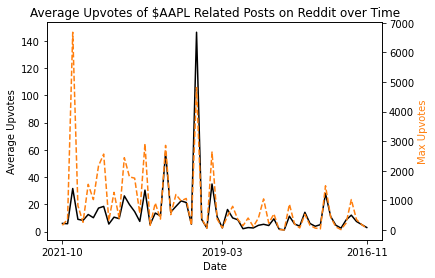

In [23]:
import matplotlib.dates as mdates

fig, ax = plt.subplots()
ax2=ax.twinx()

ax.plot(monthly_post_scores['year_month'], monthly_post_scores['monthly_mean'], color='k')
ax2.plot(monthly_post_scores['year_month'], monthly_post_scores['monthly_max'], color='tab:orange', linestyle='--')

ax.set_xlabel('Date')
ax.set_ylabel('Average Upvotes')
ax.set_title('Average Upvotes of $AAPL Related Posts on Reddit over Time')

ax.xaxis.set_major_locator(mdates.MonthLocator())
    
ax2.set_ylabel('Max Upvotes', color='tab:orange')

plt.show()

I'll later analyse this graph in combination with stock data, so no comments for now.

### Which subreddits have the highest average score?

In [24]:
top_avg = (
    clean_posts
        .groupby('subreddit')['score']
        .mean()
        .reset_index()
        .sort_values('score', ascending=False)
        )

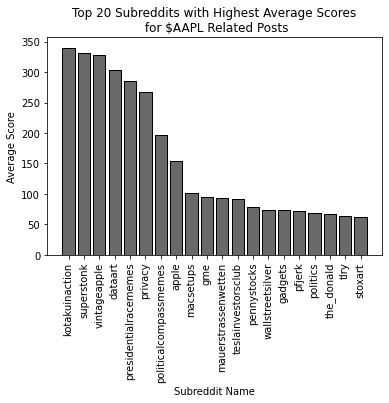

In [25]:
create_plot(top_avg.head(20), 'subreddit', 'score', color='dimgrey', edgecolor='k')

plt.xticks(rotation='vertical')
plt.xlabel('Subreddit Name')
plt.ylabel('Average Score')
plt.title('Top 20 Subreddits with Highest Average Scores\n for $AAPL Related Posts')

plt.show()

### Which subreddits have the highest scoring posts?

In [26]:
top_max = (
    clean_posts
        .groupby('subreddit')['score']
        .max()
        .reset_index()
        .sort_values('score', ascending=False)
        )

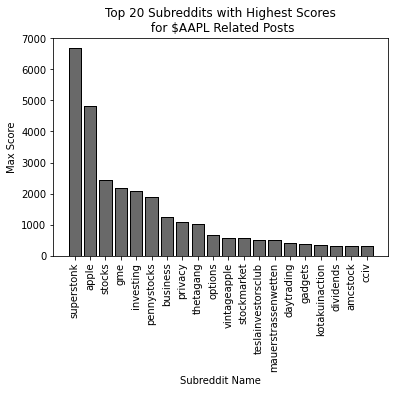

In [27]:
create_plot(top_max.head(20), 'subreddit', 'score', color='dimgrey', edgecolor='k')

plt.xticks(rotation='vertical')
plt.xlabel('Subreddit Name')
plt.ylabel('Max Score')
plt.title('Top 20 Subreddits with Highest Scores\n for $AAPL Related Posts')

plt.show()

##### For some extra insight, I plot the prior two graphs again, but this time overlaid with each sub's max, or average score.

In [28]:
avg_max_scores = pd.merge(left=top_avg, right=top_max, how='inner', left_on='subreddit', right_on='subreddit')
avg_max_scores.rename(columns={'score_x': 'average', 'score_y': 'max'}, inplace=True)

top_20_avg_sort = avg_max_scores.sort_values('average', ascending=False).head(20)
top_20_max_sort = avg_max_scores.sort_values('max', ascending=False).head(20)

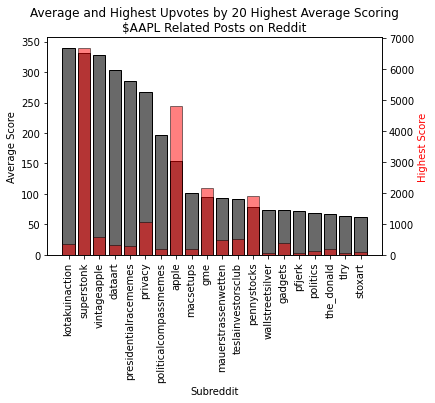

In [29]:
fig1, ax = plt.subplots()
ax1 = ax.twinx()

ax.bar(top_20_avg_sort['subreddit'], top_20_avg_sort['average'], color='dimgrey', edgecolor='k')
ax1.bar(top_20_avg_sort['subreddit'], top_20_avg_sort['max'], color='r', edgecolor='k', alpha=0.5)

ax.set_xlabel('Subreddit')
ax.set_ylabel('Average Score')
ax1.set_ylabel('Highest Score', color='r')

ax.set_title('Average and Highest Upvotes by 20 Highest Average Scoring\n$AAPL Related Posts on Reddit')

ax.tick_params('x', labelrotation=90)

plt.show()

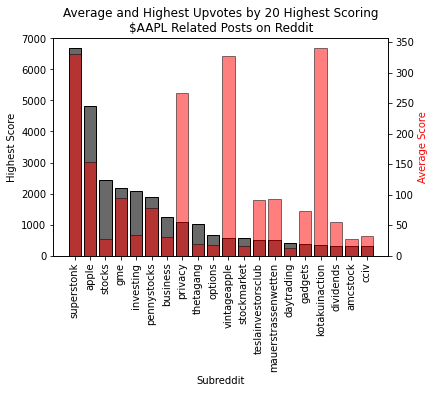

In [30]:
fig1, ax = plt.subplots()
ax1 = ax.twinx()

ax.bar(top_20_max_sort['subreddit'], top_20_max_sort['max'], color='dimgrey', edgecolor='k')
ax1.bar(top_20_max_sort['subreddit'], top_20_max_sort['average'], color='r', edgecolor='k', alpha=0.5)

ax.set_xlabel('Subreddit')
ax.set_ylabel('Highest Score')
ax1.set_ylabel('Average Score', color='r')

ax.set_title('Average and Highest Upvotes by 20 Highest Scoring\n$AAPL Related Posts on Reddit')

ax.tick_params('x', labelrotation=90)

plt.show()

No notable correlations here. 

### Do certain months receive higher scores?

Prior insights (simply looking at the most popular subreddits and their top scores, etc.) didn't warrant filtering the data too much, but we should now consider it given the results of those insights - the top scoring subs curtail after around 10 subs, and so taking a (separate) slice (as explained below) will better represent the majority of answers. 

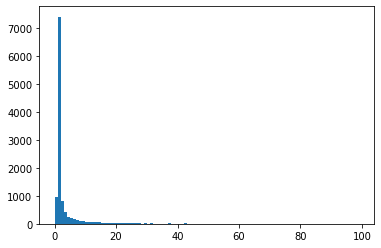

In [31]:
import numpy as np

plt.hist(clean_posts['score'], bins=[_ for _ in np.arange(0, 100, 1)])
plt.show()

In [32]:
print(f"The first 71% of values are equal to or less than {clean_posts['score'].quantile(0.71)}")
print(f"The first 72% of values are equal to or less than {clean_posts['score'].quantile(0.72)}")

The first 71% of values are equal to or less than 1.0
The first 72% of values are equal to or less than 2.0


The vast majority (72%) of values are less than or equal to 1.

I therefore create a new series for top posts, just to get an idea of trends, while keeping the clean_posts data as itself. This allows me to more easily compare the top posts to the whole dataset, where the axes is not terribly skewed by the (very) top values. This series contains values between the top 10% and top 1% of values.

In [33]:
pctl_90 = clean_posts['score'].quantile(0.9)
pctl_99 = clean_posts['score'].quantile(0.99)

top_posts = clean_posts[(clean_posts['score'] > pctl_90) & (clean_posts['score'] > pctl_90)]
month_scores = top_posts.groupby(['month_created', 'year_created'])['score'].mean().reset_index()

print(f'90th Percentile: {pctl_90}')
print(f'99th Percentile: {pctl_99}')

90th Percentile: 9.0
99th Percentile: 181.89999999999964


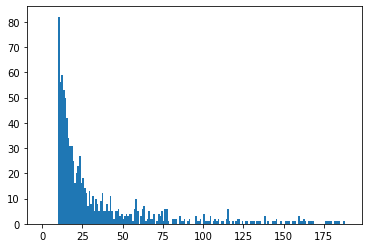

In [34]:
plt.hist(top_posts['score'], bins=[_ for _ in np.arange(0, 190, 1)])
plt.show()

Data is still positively skewed, but notably less so.

#### From hereon, posts with scores which lie between the 90th and 99th percentile will be referred to as 'top posts' in commentary. 

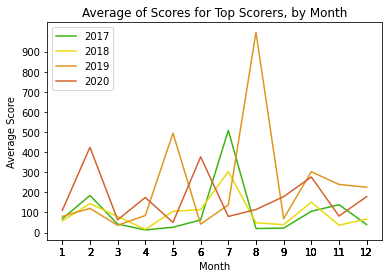

In [35]:
import time
from IPython import display      

colors = {2017:'#3bb410', 2018:'#e9da10', 2019:'#df951e', 2020:'#d2622f', 2021:'#c44141'}
years = [2017, 2018, 2019, 2020]

plt.xticks(month_scores['month_created'])
plt.xlabel('Month')
plt.ylabel('Average Score')
plt.yticks(range(0, 1000, 100))
plt.title('Average of Scores for Top Scorers, by Month')

for year in years:
    plt.plot(
        month_scores[month_scores['year_created'] == year]['month_created'],
        month_scores[month_scores['year_created'] == year]['score'],
        color=colors[year],
        label=year)
          
    plt.legend(loc='upper left')
        
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1.0)
    
plt.show()

#### Re-run this cell to animate!

Average score seems to spike around the middle of the year, notably so between May and August. Analysing $AAPL stock data for each month will be interesting.

### What about weekday?

In [36]:
all_weekday = clean_posts.copy()
top_weekday = top_posts.copy()

for df in [all_weekday, top_weekday]:
    df['weekday'] = df['date_created'].dt.strftime('%A') 

cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

all_weekday['all_weekday_mean'] = all_weekday.groupby('weekday')['score'].transform('mean')
all_weekday['all_weekday_count'] = all_weekday.groupby('weekday')['id'].transform('count')

all_weekday['top_weekday_mean'] = top_weekday.groupby('weekday')['score'].transform('mean')
all_weekday['top_weekday_count'] = top_weekday.groupby('weekday')['id'].transform('count')

weekday_posts = (all_weekday.groupby('weekday').mean().reindex(cats))

In [37]:
all_weekday.head()

,id,subreddit,date_created,selftext,title,score,year_created,month_created,day_created,hour_created,sub_posts,weekday,all_weekday_mean,all_weekday_count,top_weekday_mean,top_weekday_count
0,qjx7sk,dividends,2021-10-31 19:48:40,I have created a package of dividend stocks by...,Why is AAPL included in dividend ETFs?,7,2021,10,31,19,23,Sunday,8.937634,930,NaN,NaN
1,qjx3kk,aapl,2021-10-31 19:42:55,The market has now gifted MSFT (a great but in...,why AAPL deserves $200+ and a 35+ PE,7,2021,10,31,19,178,Sunday,8.937634,930,NaN,NaN
2,qjvocf,ultraalgo,2021-10-31 18:34:12,NaN,$AAPL waiting for Buy signal on AAPL https://t...,1,2021,10,31,18,407,Sunday,8.937634,930,NaN,NaN
3,qjvo1l,stocks,2021-10-31 18:33:50,I've got about 5.5% AAPL and 11.1% MSFT. I'm ...,Sell a few AAPL shares and buy CRM?,8,2021,10,31,18,865,Sunday,8.937634,930,NaN,NaN
4,qjtshr,stocks,2021-10-31 17:02:20,I’m a broke college student but I have enough ...,Is $AAPL able to grow much more?,162,2021,10,31,17,865,Sunday,8.937634,930,93.171053,76.0


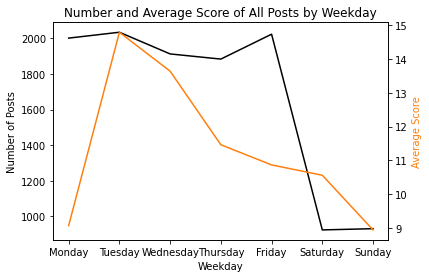

In [38]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(weekday_posts.index, weekday_posts['all_weekday_count'], color='k')
ax2.plot(weekday_posts.index, weekday_posts['all_weekday_mean'], color='tab:orange')

ax.set_xlabel('Weekday')
ax.set_ylabel('Number of Posts')
ax2.set_ylabel('Average Score', color='tab:orange')

ax.set_title('Number and Average Score of All Posts by Weekday')

plt.show()

As the week progresses, the number of posts stays consistent until the weekend. This is expected; market is closed on the weekend (thus no concurrent activity to discuss). The average score of posts decreaes across the week, and rises again on Monday. Potential reasons could include excitement for stock market re-open, people not wanting to hold short term positions over the weekend and therefore not interacting with posts, or people deciding/discussing their positions at the start of the week. 

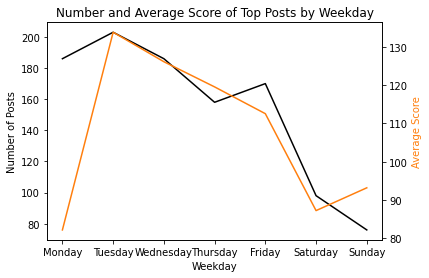

In [39]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(weekday_posts.index, weekday_posts['top_weekday_count'], color='k')
ax2.plot(weekday_posts.index, weekday_posts['top_weekday_mean'], color='tab:orange')

ax.set_xlabel('Weekday')
ax.set_ylabel('Number of Posts')
ax2.set_ylabel('Average Score', color='tab:orange')

ax.set_title('Number and Average Score of Top Posts by Weekday')

plt.show()

The top posts follow a very similar trend.

### How do the score and count of posts vary by time of day?

In [40]:
all_hour_count = clean_posts.groupby('hour_created')['id'].count().reset_index()
all_hour_avg_score = clean_posts.groupby('hour_created')['score'].mean().reset_index()

top_hour_avg_score = top_posts.groupby('hour_created')['score'].mean().reset_index()
top_hour_avg_count = top_posts.groupby('hour_created')['id'].count().reset_index()

##### Set larger fig size

In [41]:
plt.rcParams["figure.figsize"] = (10, 7)

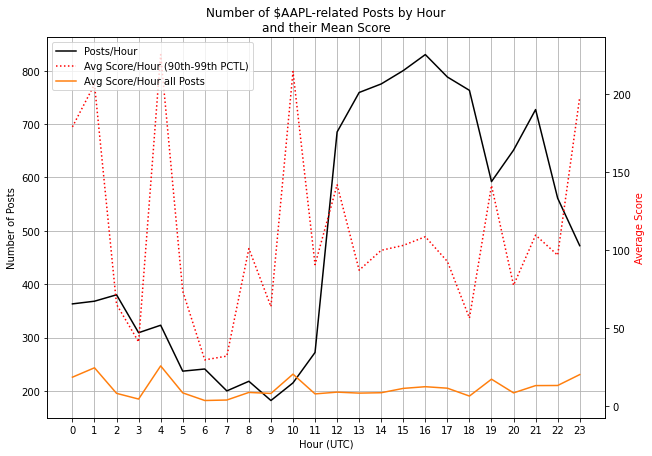

In [42]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(
    all_hour_count['hour_created'],
    all_hour_count['id'],
    color='k',
    label='Posts/Hour'
)
ax2.plot(
    top_hour_avg_score['hour_created'],
    top_hour_avg_score['score'],
    label='Avg Score/Hour (90th-99th PCTL)',
    linestyle='dotted',
    color='r'
)
ax2.plot(
    all_hour_avg_score['hour_created'],
    all_hour_avg_score['score'],
    label='Avg Score/Hour all Posts',
    color='tab:orange'
)

ax.set_xticks(all_hour_count['hour_created'])
ax.set_xlabel('Hour (UTC)')
ax.set_ylabel('Number of Posts')
ax.set_title('Number of $AAPL-related Posts by Hour\nand their Mean Score')

ax2.set_ylabel('Average Score', color='r')

handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax2.legend(handles + handles2, labels + labels2, loc='upper left')

ax.grid()
plt.show()

To a degree, it seems that the highest scoring posts lag behind when the number of posts is highest. That is, posting between the hours of 9am and 12pm, before the post-quantity upturn between 11am and 4pm, results in the highest scoring $AAPL related posts. Most notably, the quantity of posts begins to steeply rise at NASDAQ pre-market open and LSE market-open (9am UTC), with number of posts beginning to reach its peak at around NASDAQ market open (2:30pm UTC). AAPL-related posts briefly decrease in quantity at 7pm UTC, perhaps a result of dinner times in the United Kingdom, lunch times in the US, or stable market conditions prior to end-of-day trading. Post-quantity sharply decreases following market-close (9pm UTC) until pre-market open.

Given that post-score rises in combination with pre-market open, it could be hypothesised that due-diligence posts are at lease partially responsible; discussion/reasoning around market-plays in this period is valuable towards deciding the positions one will take at market open. In tandem, at market close, post-score average takes a turn updwards for the highest scoring posts (and to a lesser degree, for all posts); people are discussing the market conditions for the day, and the positions they will take on the following day. Let's explore that hypothesis.

#### Sets figsize back to normal for all subsequent plots

In [43]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [44]:
all_DD, top_DD, wsb_DD = clean_posts.copy(), top_posts.copy(), WSB_posts.copy()

dataframes = [
    df[(df['title'].str.contains('DD|diligence|due diligence')==True) 
       | (df['selftext'].str.contains('DD|diligence|due diligence')==True)
      ] for df in [all_DD, top_DD, wsb_DD]
    ]

mean_dfs = [df.groupby('hour_created')['score'].mean().reset_index() for df in dataframes]
count_dfs = [df.groupby('hour_created')['id'].count().reset_index() for df in dataframes]

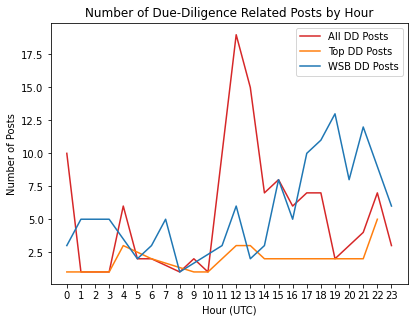

In [45]:
labels = {0: 'All DD Posts', 1: 'Top DD Posts', 2: 'WSB DD Posts'}
colors = {0: 'tab:red', 1: 'tab:orange', 2: 'tab:blue'}   

create_plot([df for df in count_dfs], 'hour_created', 'id', line=True, label=labels, color=colors)
        
plt.xticks(all_hour_count['hour_created'])
plt.xlabel('Hour (UTC)')
plt.ylabel('Number of Posts')
plt.title('Number of Due-Diligence Related Posts by Hour')

plt.legend()
plt.show()

DD for all posts (non-WSB) posts increases dramatically at pre-market open (9am UTC). This is expected, given that people are deciding/discussing their positions prior to the trading period. At NASDAQ market open (2:30 UTC), post-volume begins to decrease, and then rises somewhat after market close until midnight UTC. 

A higher number of Top DD and WSB DD posts are made later in the day (towards market close); for WSB, this might reflect something as little as a US-centric user base, or as much as more sporadic trading behaviour (i.e. more focus on day-trading). 

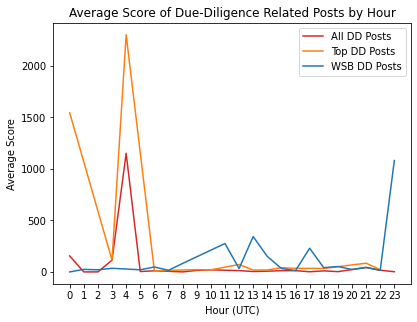

In [46]:
create_plot([df for df in mean_dfs], 'hour_created', 'score', line=True, labels=labels, colors=colors)

plt.xticks(all_hour_count['hour_created'])
plt.xlabel('Hour (UTC)')
plt.ylabel('Average Score')
plt.title('Average Score of Due-Diligence Related Posts by Hour')

plt.legend()
plt.show()

While there is a relatively little number of posts with 'DD' or 'diligence' mentioned, such posts do exercise leverage during premarket hours on those where DD is not mentioned (see 'Number of $AAPL-related Posts by Hour and their Mean Score' plot). See, in particular, the higher average scores for top-DD posts at 4am UTC (end of after-market). WSB are upvoted throughout trading hours when post-quantity is high, but receive a spike in upvotes after market close, despite a decline in post-quantity. Therefore, posting DD to WSB at 11pm UTC will result in the highest likelihood of having a highly upvoted post (a drop in post-quantity but a rise in average score).

I won't be exploring this further with statistical testing, as the analysis was just for practice/fun, and analysis of reddit data was really meant to be preliminary. 

## <ins>Start of Comment Analysis</ins>

##### Ensure correct column changes were made to clean and WSB dataframes.

In [47]:
print(monthly_comm_scores.shape)
print(monthly_wsb_comms.shape)

(117029, 13)
(180504, 13)


In [48]:
for df in [monthly_comm_scores, monthly_wsb_comms]:
    df['ymd'] = df['date_created'].dt.strftime('%Y-%m-%d')

In [49]:
sentiment_clean = (
    monthly_comm_scores[clean_comms['sentiment'].notna()]
    .groupby('ymd')
    .mean()
    .reset_index()
    )

sentiment_wsb = (
    monthly_wsb_comms[WSB_comms['sentiment'].notna()]
    .groupby('ymd')
    .mean()
    .reset_index()
    )

sentiment_clean_mean = sentiment_clean.groupby('year_created')['sentiment'].mean().reset_index()
sentiment_wsb_mean = sentiment_wsb.groupby('year_created')['sentiment'].mean().reset_index()

sentiment_clean.head()

,ymd,sentiment,score,year_created,month_created,day_created,hour_created,monthly_mean,monthly_max
0,2016-11-01,0.245567,1.750000,2016.0,11.0,1.0,13.416667,4.863014,313.0
1,2016-11-02,0.291927,3.545455,2016.0,11.0,2.0,16.909091,4.863014,313.0
2,2016-11-03,0.552500,1.444444,2016.0,11.0,3.0,10.111111,4.863014,313.0
3,2016-11-04,0.168590,8.100000,2016.0,11.0,4.0,13.000000,4.863014,313.0
4,2016-11-05,0.474087,3.000000,2016.0,11.0,5.0,16.875000,4.863014,313.0


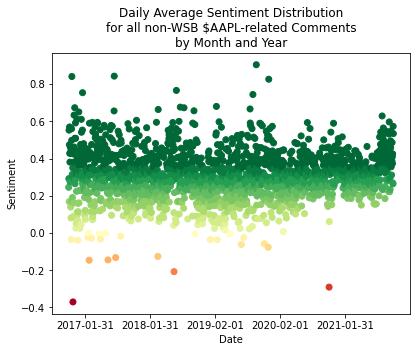

In [50]:
from matplotlib.colors import BoundaryNorm

#This cell uses code from:
# https://stackoverflow.com/questions/23994020/colorplot-that-distinguishes-between-positive-and-negative-values

fig, ax = plt.subplots()
  
cmap = plt.get_cmap('RdYlGn')
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize, forcing 0 to be part of the colorbar.
bounds = np.arange(np.min(-0.4),np.max(0.4),.03)
idx=np.searchsorted(bounds,0)
bounds=np.insert(bounds,idx,0)
norm = BoundaryNorm(bounds, cmap.N)
    
ax.scatter(sentiment_clean['ymd'],
           sentiment_clean['sentiment'],
           c=sentiment_clean['sentiment'], norm=norm, cmap=cmap)

ax.set_xlabel('Date')
ax.set_ylabel('Sentiment')
ax.set_yticks(np.arange(-0.4, 0.8, 0.2))
ax.set_title('Daily Average Sentiment Distribution\nfor all non-WSB $AAPL-related Comments\nby Month and Year')

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=12))
plt.show()

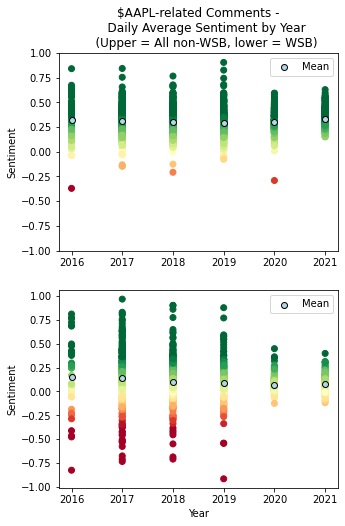

In [51]:
# 2 rows 1 col
fig, ax = plt.subplots(2, 1, figsize=(5, 8))

dfs = [sentiment_clean, sentiment_wsb]
df_means = [sentiment_clean_mean, sentiment_wsb_mean]

for i, (df, dfmean) in enumerate(zip(dfs, df_means)):
    ax[i].scatter(
        df['year_created'],
        df['sentiment'],
        c=df['sentiment'], norm=norm, cmap=cmap)
        
    ax[i].scatter(
        dfmean['year_created'],
        dfmean['sentiment'],
        color='lightblue', edgecolor='k',
        label='Mean')
    
    ax[i].legend()
    ax[i].set_ylabel('Sentiment')

ax[0].set_yticks(np.arange(-1, 1.2, 0.25))
ax[0].set_title(
    '''$AAPL-related Comments -
    Daily Average Sentiment by Year
    (Upper = All non-WSB, lower = WSB)''')

ax[1].set_xlabel('Year')

plt.show()

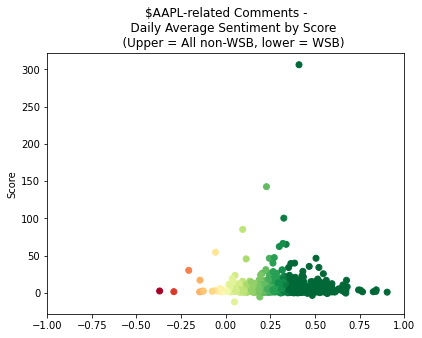

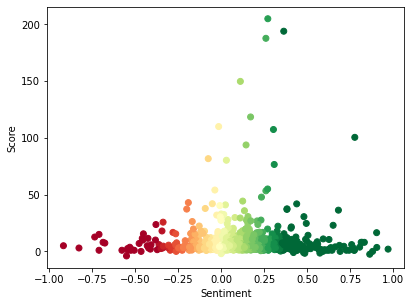

In [52]:
fig, ax = plt.subplots()
fig, ax2 = plt.subplots()

ax.scatter(sentiment_clean['sentiment'],
            sentiment_clean['score'],
            c=sentiment_clean['sentiment'], norm=norm, cmap=cmap,)

ax2.scatter(sentiment_wsb['sentiment'],
            sentiment_wsb['score'],
            c=sentiment_wsb['sentiment'], norm=norm, cmap=cmap)

for axs in [ax, ax2]:
    axs.set_xticks(np.arange(-1, 1.2, 0.25))
    axs.set_ylabel('Score')
    
ax2.set_xlabel('Sentiment')

ax.set_title(
    '''$AAPL-related Comments -
    Daily Average Sentiment by Score
    (Upper = All non-WSB, lower = WSB)''')

plt.show()

## <ins>Start of Stock Analysis</ins>

### Use mplfinance for candlesticks
#### How does reddit activity change with stock price?
#### How do upvotes change with stock price?

In [53]:
import mplfinance as mpf

raw_stock_data = pd.read_csv(cwd + '//AAPL Stock Data//AAPL-Stock-Data.csv', index_col='Date', parse_dates=True)
raw_stock_data.isnull().values.any()

False

In [54]:
raw_stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100600,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095352,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088353,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090540,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093165,73449600


#### Unfortunately, we only have date values (no time data). Analysis will therefore only be conducted on post/comment values by day. 

##### We need to get date values beginning from November 1st 2016, the starting date for posts and comments.

In [55]:
raw_stock_data = raw_stock_data[raw_stock_data.index >= '2016-11-01']

In [56]:
raw_stock_data
weekly_stock_data = raw_stock_data.resample('W-Mon').mean()
monthly_stock_data = raw_stock_data.resample('M').mean()

monthly_stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-30,27.520595,27.767143,27.247143,27.538571,25.946600,1.374390e+08
2016-12-31,28.498928,28.756309,28.386309,28.583929,26.944799,1.159565e+08
2017-01-31,29.773375,29.970250,29.696375,29.892500,28.178332,1.126244e+08
2017-02-28,33.308684,33.540395,33.209210,33.428552,31.606276,1.210460e+08
2017-03-31,35.090544,35.299456,34.927283,35.154457,33.282219,9.767450e+07


In [57]:
sentiment_clean_monthly = (sentiment_clean
                               .groupby(['year_created', 'month_created'])
                               .mean()
                               .reset_index())
sentiment_wsb_monthly = (sentiment_wsb
                               .groupby(['year_created', 'month_created'])
                               .mean()
                               .reset_index())
sentiment_clean_monthly.head()

,year_created,month_created,sentiment,score,day_created,hour_created,monthly_mean,monthly_max
0,2016.0,11.0,0.311578,4.320193,15.172414,13.122101,4.863014,313.0
1,2016.0,12.0,0.325712,4.746011,16.000000,14.038762,3.717314,153.0
2,2017.0,1.0,0.360174,7.187407,16.000000,12.647039,6.470738,276.0
3,2017.0,2.0,0.286363,3.421214,14.500000,12.526997,3.436759,66.0
4,2017.0,3.0,0.292685,4.037154,16.000000,12.610834,3.684701,159.0


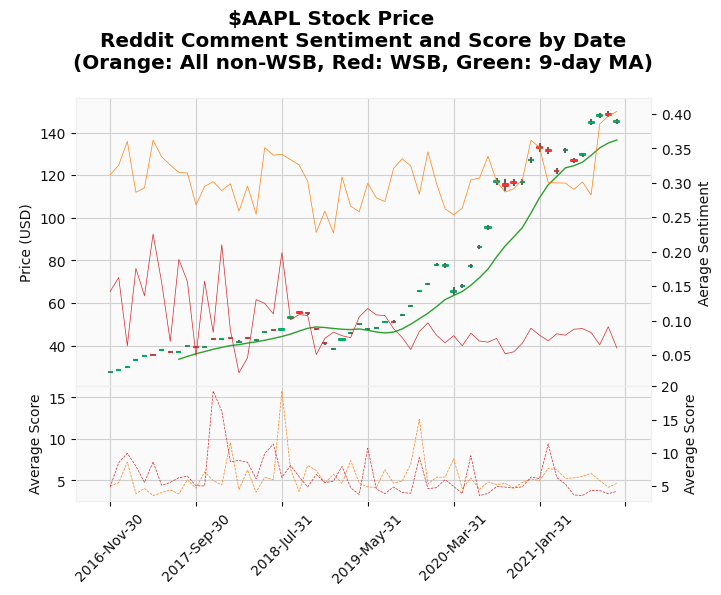

In [58]:
apds = []
dfs = [sentiment_clean_monthly, sentiment_wsb_monthly]
colors = {0: 'tab:orange', 1: 'tab:red'}

for i, df in enumerate(dfs):
    apds.append(mpf.make_addplot(df['sentiment'],
                    width=0.5, color=colors[i],
                    ylabel='Aerage Sentiment')
               )
    apds.append(mpf.make_addplot(df['score'],
                    width=0.5, color=colors[i],
                    panel=1,
                    ylabel='Average Score', linestyle = '--')
               )

s = mpf.make_mpf_style(base_mpf_style='yahoo', y_on_right=False)

mpf.plot(monthly_stock_data,
         mav=(0, 0, 9),
         update_width_config=dict(candle_width=0.6, candle_linewidth=1.5, line_width=1),
         type='candlestick', style=s,
         addplot=apds, figscale=1,
         ylabel='Price (USD)',
         title='''$AAPL Stock Price
         Reddit Comment Sentiment and Score by Date
         (Orange: All non-WSB, Red: WSB, Green: 9-day MA)'''
        )